## 1. Loading the data

In [37]:
from dataset import SubjectTrialDataset
from subject_mgh import MGHSubject
import torch
from model_model import BFModule
from model_transformers import Transformer
import torch.nn as nn
from train_utils import log

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

subject_id, trial_id = 1, 3
window_size = 1280
subject = MGHSubject(subject_id, cache=True, use_h5_file=True)

Using device: cuda


## 2. Separating the EEG and iEEG channels

In [38]:

EEG_channels = ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'C3', 'Cz', 'C4', 'P3', 'Pz', 'P4', 'O1', 'O2', 'F7', 'F8', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6']
EEG_CHANNEL_NAME_MAPPING = {
    'T3': 'T7',
    'T4': 'T8',
    'T5': 'P7',
    'T6': 'P8'
}
EEG_channels.extend(list(EEG_CHANNEL_NAME_MAPPING.values()))
EEG_channels = [e.upper() for e in EEG_channels]

electrode_map = {}
n_eeg_electrodes, n_ieeg_electrodes = 0, 0
for electrode_label in subject.get_electrode_labels(session_id=trial_id):
    key = ('mgh'+str(subject_id), electrode_label)
    if electrode_label.startswith('C2'): # mark those channels as corrupted
        electrode_map[key] = -1
    elif electrode_label in EEG_channels:
        electrode_map[key] = 1 # we will use index "1" for EEG channels
        n_eeg_electrodes += 1
    else:
        electrode_map[key] = 0 # we will use index "0" for non-EEG (iEEG) channels. The rest (EMG, EKG, etc.) will be ignored by the Subject class already
        n_ieeg_electrodes += 1
print(f"EEG channels ({n_eeg_electrodes}):\n  " + ", ".join(key[1] for key, value in electrode_map.items() if value == 1))
print(f"\niEEG channels ({n_ieeg_electrodes}):\n  " + ", ".join(key[1] for key, value in electrode_map.items() if value == 0))
print(f"\nCorrupted channels:\n  " + ", ".join(key[1] for key, value in electrode_map.items() if value == -1))


EEG channels (21):
  FP1, F7, T3, T5, O1, F3, C3, P3, FP2, F8, T4, T6, O2, F4, C4, P4, FZ, CZ, PZ, T1, T2

iEEG channels (186):
  LFIa1, LFIa2, LFIa3, LFIa4, LFIa5, LFIa6, LFIa7, LFIa8, LFIa9, LFIa10, LFIa11, LFIa12, LFIa13, LFIa14, LFIa15, LFIa16, LFIb1, LFIb2, LFIb3, LFIb4, LFIb5, LFIb6, LFIb7, LFIb8, LFIb9, LFIb10, LFIb11, LFIb12, LFIb13, LFIb14, LFIb15, LFIb16, LPI1, LPI2, LPI3, LPI4, LPI5, LPI6, LPI7, LPI8, LPI9, LPI10, LPI11, LPI12, LPI13, LPI14, LPI15, LPI16, LTS1, LTS2, LTS3, LTS4, LTS5, LTS6, LTS7, LTS8, LTS9, LTS10, LTS11, LTS12, LTS13, LTS14, LTS15, LTS16, LAMY1, LAMY2, LAMY3, LAMY4, LAMY5, LAMY6, LAMY7, LAMY8, LAMY9, LAMY10, LAMY11, LAMY12, LHH1, LHH2, LHH3, LHH4, LHH5, LHH6, LHH7, LHH8, LHH9, LHH10, LHH11, LHH12, LHH13, LHH14, LHT1, LHT2, LHT3, LHT4, LHT5, LHT6, LHT7, LHT8, LHT9, LHT10, LHT11, LHT12, LTB1, LTB2, LTB3, LTB4, LTB5, LTB6, LTB7, LTB8, LTB9, LTB10, LTB11, LTB12, LO1, LO2, LO3, LO4, LO5, LO6, LO7, LO8, LO9, LO10, LO11, LO12, LO13, LO14, LPOi1, LPOi2, LPOi3, LPOi

In [39]:
dataset = SubjectTrialDataset(subject, trial_id, window_size=window_size, dtype=torch.float32, output_embeddings_map=electrode_map)
print("Shape of dataset[0]['data']:", dataset[0]['data'].shape)
print("Shape of dataset[0]['electrode_index']:", dataset[0]['electrode_index'].shape)
dataset[0]

Shape of dataset[0]['data']: torch.Size([250, 1280])
Shape of dataset[0]['electrode_index']: torch.Size([250])


{'data': tensor([[ 1.4621e-06, -2.2597e-06,  1.1564e-05,  ..., -2.2198e-05,
          -2.1134e-05, -1.8742e-05],
         [ 2.6717e-05,  2.1134e-05,  3.5490e-05,  ..., -1.3425e-05,
          -1.1032e-05, -8.9057e-06],
         [ 3.2566e-05,  2.9641e-05,  4.5326e-05,  ..., -3.2832e-05,
          -3.3363e-05, -3.3629e-05],
         ...,
         [-2.2557e-04, -9.0254e-05, -5.5428e-05,  ..., -5.2504e-05,
          -1.0089e-04, -1.9181e-04],
         [-2.0935e-04, -7.9886e-05, -4.9048e-05,  ..., -5.4631e-05,
          -1.0567e-04, -1.9048e-04],
         [-1.1896e-04, -3.5224e-05, -3.6022e-05,  ..., -1.4754e-05,
          -5.3833e-05, -1.1790e-04]]),
 'electrode_index': tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

## 3. Define the model

In [48]:
class Embed(BFModule):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(d_input, d_model)
    def forward(self, x):
        return self.embed(x)

class Linear_L2(BFModule):
    def __init__(self, n_electrodes, n_context_timebins, n_samples_per_bin):
        super().__init__()
        self.n_electrodes = n_electrodes
        self.n_context_timebins = n_context_timebins
        self.n_samples_per_bin = n_samples_per_bin
        self.linear = nn.Linear(n_electrodes * n_context_timebins * n_samples_per_bin, n_samples_per_bin)

    def forward(self, x):
        # x shape: (batch_size, n_electrodes, n_timebins, n_samples_per_bin)
        # output shape: (batch_size, 1, n_timebins-n_context_timebins, n_samples_per_bin)
        batch_size = x.shape[0]
        n_timebins = x.shape[2]
        
        # Create output tensor to store predictions for each timebin
        output = torch.zeros(batch_size, 1, n_timebins-self.n_context_timebins, self.n_samples_per_bin).to(x.device)
        
        # For each timebin, look at context window and predict
        for t in range(n_timebins-self.n_context_timebins):
            # Get start and end indices for context window
            start_idx = t
            end_idx = t + self.n_context_timebins
            
            # Extract context window
            context = x[:, :, start_idx:end_idx, :]
            
            # Flatten the context window
            context_flat = context.reshape(batch_size, -1)
            
            # Make prediction for current timebin
            output[:, 0, t, :] = self.linear(context_flat)

        return output
    
    def calculate_loss(self, x, y):
        output = self.forward(x)

        return nn.functional.mse_loss(output, y[:, :, self.n_context_timebins:, :])


## 4. Train the model

In [51]:
n_steps = 100
batch_size = 128
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

ieeg_index = 10

n_samples_per_bin = 1

model = Linear_L2(n_electrodes=n_eeg_electrodes, n_context_timebins=10, n_samples_per_bin=n_samples_per_bin).to(device)

initial_lr = 0.0003
use_muon = False
optimizers = []
schedulers = []
if use_muon:
    from muon import Muon
    all_params = list(model.parameters())
    matrix_params = [p for p in all_params if p.ndim >= 2]
    other_params = [p for p in all_params if p.ndim < 2]
    optimizers.append(Muon(matrix_params, lr=initial_lr, momentum=0.95, nesterov=True, backend='newtonschulz5', backend_steps=5))
    optimizers.append(torch.optim.AdamW(other_params, lr=initial_lr, betas=(0.9, 0.95)))
    schedulers.append(None)  # Muon doesn't support schedulers
    schedulers.append(torch.optim.lr_scheduler.LinearLR(optimizers[1], start_factor=1.0, end_factor=0.0, total_iters=n_steps))
else:
    optimizers = [torch.optim.AdamW(model.parameters(), lr=initial_lr, betas=(0.9, 0.95))]
    schedulers = [torch.optim.lr_scheduler.LinearLR(optimizers[0], start_factor=1.0, end_factor=0.0, total_iters=n_steps)]

step = 1
for batch in dataloader:
    electrode_index = batch['electrode_index'].squeeze(-1) # shape: (batch_size, n_electrodes)

    batch_data_eeg = batch['data'][electrode_index == 1, :].reshape(batch_size, -1, window_size//n_samples_per_bin, n_samples_per_bin).to(device)
    batch_data_ieeg = batch['data'][electrode_index == 0, :].reshape(batch_size, -1, window_size//n_samples_per_bin, n_samples_per_bin).to(device)
    batch_data_ieeg = batch_data_ieeg[:, ieeg_index:ieeg_index+1, :, :]
    #print("EEG batch shape:", batch_data_eeg.shape, "\niEEG batch shape:", batch_data_ieeg.shape)
    #break

    loss = model.calculate_loss(batch_data_eeg, batch_data_ieeg)
    loss.backward()
    for optimizer in optimizers:
        optimizer.step()
    
    # Step the schedulers
    for scheduler in schedulers:
        if scheduler is not None:
            scheduler.step()
    
    if step % 10 == 0:
        current_lr = optimizers[-1].param_groups[0]['lr']
        print(f"Step {step}, Loss: {loss.item()}, LR: {current_lr:.6f}")
        
    if step == n_steps:
        break # Only process one batch per step
    step += 1


Step 10, Loss: 0.00040168556733988225, LR: 0.000270
Step 20, Loss: 0.0003040370938833803, LR: 0.000240
Step 30, Loss: 0.00022621656535193324, LR: 0.000210
Step 40, Loss: 0.0001659895060583949, LR: 0.000180
Step 50, Loss: 0.00012204162339912727, LR: 0.000150
Step 60, Loss: 9.054937254404649e-05, LR: 0.000120
Step 70, Loss: 6.944084452698007e-05, LR: 0.000090
Step 80, Loss: 5.593500463874079e-05, LR: 0.000060


In [161]:
import random

vocab_size = 10000
vocab = []
for i in range(vocab_size // (window_size // n_samples_per_bin)):
    vocab.append(dataset[random.randint(0, len(dataset)-1)]['data'].reshape(window_size//n_samples_per_bin, n_samples_per_bin))
    vocab[-1] /= 100
vocab = torch.cat(vocab, dim=0)
vocab = vocab.to(device)
vocab_size = len(vocab)
print(vocab.shape)

torch.Size([10000, 64])


torch.Size([1, 21, 1280, 1]) torch.Size([1, 1, 1280, 1])


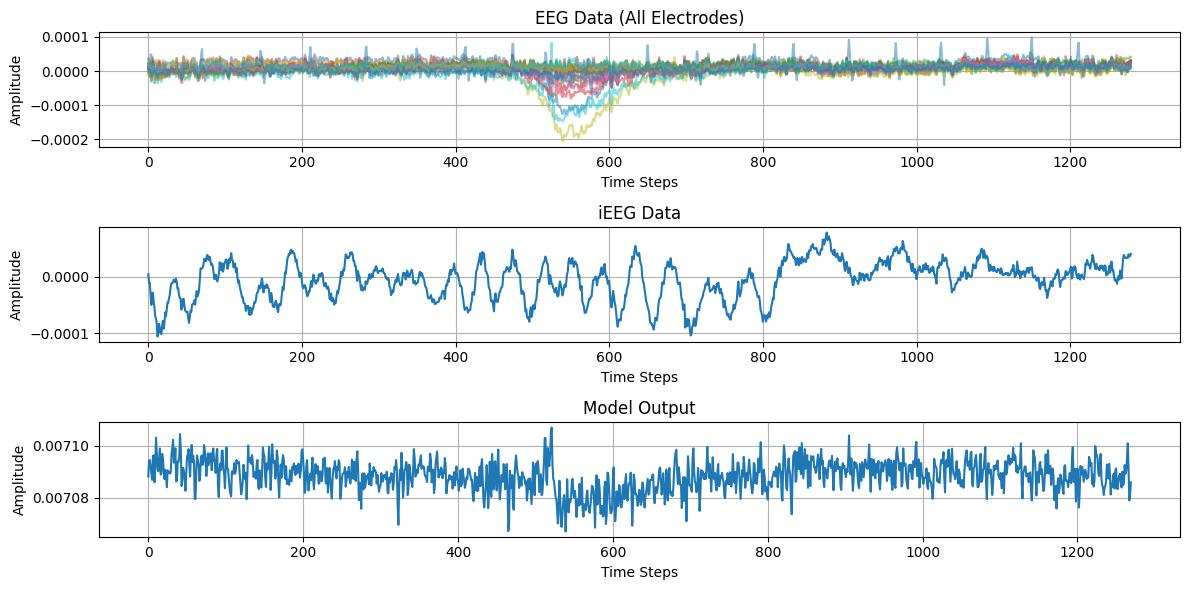

Model output shape: (1, 1, 1270, 1)


In [68]:
generate_steps = 5
n_generations = 100
batch_index = 100

electrode_index = dataset[batch_index]['electrode_index'].squeeze(-1) # shape: (batch_size, n_electrodes)

batch_data_eeg = dataset[batch_index]['data'][electrode_index == 1, :].reshape(-1, window_size//n_samples_per_bin, n_samples_per_bin).to(device).unsqueeze(0)
batch_data_ieeg = dataset[batch_index]['data'][electrode_index == 0, :].reshape(-1, window_size//n_samples_per_bin, n_samples_per_bin).to(device).unsqueeze(0)
batch_data_ieeg = batch_data_ieeg[:, ieeg_index:ieeg_index+1, :, :]

print(batch_data_eeg.shape, batch_data_ieeg.shape)

import matplotlib.pyplot as plt
# Plot EEG and iEEG data
plt.figure(figsize=(12, 6))

# Plot EEG data
eeg_data = batch_data_eeg.squeeze().cpu().numpy()
plt.subplot(3, 1, 1)
for electrode in range(eeg_data.shape[0]):
    plt.plot(eeg_data[electrode].flatten(), alpha=0.5)
plt.title('EEG Data (All Electrodes)')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

# Plot iEEG data 
ieeg_data = batch_data_ieeg.squeeze().cpu().numpy()
plt.subplot(3, 1, 2)
plt.plot(ieeg_data.flatten())
plt.title('iEEG Data')
plt.xlabel('Time Steps') 
plt.ylabel('Amplitude')
plt.grid(True)

# Plot model output
model_output = model(batch_data_eeg).detach().cpu().numpy()
plt.subplot(3, 1, 3)
plt.plot(model_output.flatten())
plt.title('Model Output')
plt.xlabel('Time Steps')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

print("Model output shape:", model_output.shape)
